# A Ranking Stability Measure for Quantifying the Robustness of Anomaly Detection Methods (EDML 2020 Workshop Paper)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
import random
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans
from stability import *

def ignore_warnings():
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)

ignore_warnings()

# Generate Data

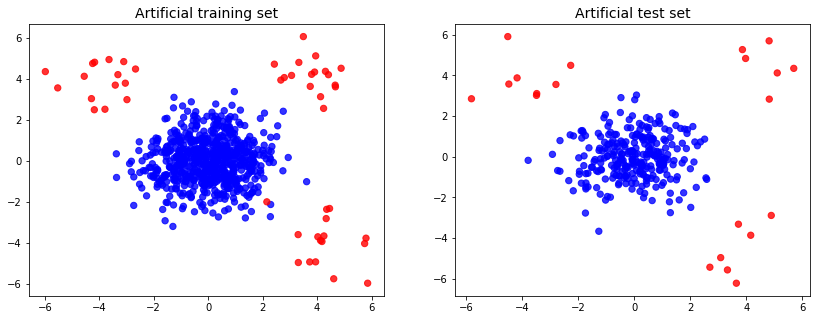

In [2]:
np.random.seed(331)
dataset_size = 1000
numerical_col = ['dim_1','dim_2']
class_prior = 0.93 #real class prior
gamma = 1-class_prior

#Training set
a1_ = np.random.randn(2, np.int(dataset_size*(1-class_prior)/3))
a2_ = np.random.randn(2, np.int(dataset_size*(1-class_prior)/3))
a3_ = np.random.randn(2, np.int(dataset_size*gamma) - 2*np.int(dataset_size*(1-class_prior)/3))
num_anom = a1_.shape[1] + a2_.shape[1]+ a3_.shape[1]

n1_ = np.random.randn(2, np.int(dataset_size-num_anom))*1.1
y = np.zeros(dataset_size, dtype=np.int)
y[:num_anom] = +1


a1_[0, :] += 4.0
a1_[1, :] -= 4.0
a2_[0, :] -= 4.0
a2_[1, :] += 4.0
a3_[0, :] += 4.0
a3_[1, :] += 4.0

data_set = np.concatenate((a1_, a2_, a3_, n1_), axis=1)

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=331)
for train_index, test_index in sss.split(data_set.T, y):
    X_train, X_test = data_set.T[train_index], data_set.T[test_index]
    y_train, y_test = y[train_index], y[test_index]

n = len(y_train)
m = len(y_test)
num_train_anom = np.count_nonzero(y_train)

#Plot training and test sets
fig = plt.figure(figsize=(14, 5), facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
colors = np.array(['b' if y_train[i] == 0 else 'r' for i in range(n)])# ['g', 'r'])
plt.scatter(X_train.T[0],X_train.T[1], 40, colors, alpha = 0.8)
plt.title("Artificial training set", fontsize=14)
plt.subplot(1, 2, 2)
colors = np.array(['b' if y_test[i] == 0 else 'r' for i in range(m)])# ['g', 'r'])
plt.scatter(X_test.T[0],X_test.T[1], 40, colors, alpha = 0.8)
plt.title("Artificial test set", fontsize=14)
plt.show()

## Ranking Stability Measure Under Uniform Sampling Strategy

In [3]:
# Prepare the models that we will pass as input of the stability_measure function

knno = KNN(n_neighbors=5, contamination=gamma)
iforest = IForest(contamination=gamma, random_state = 331)
lof = LOF(n_neighbors=5, contamination=gamma)

In [4]:
                            #UNIFORM sample weights
knno_stab_unif, knno_inst_unif = stability_measure(X_train, X_test, knno, gamma, unif = True)

iforest_stab_unif, iforest_inst_unif = stability_measure(X_train, X_test, iforest, gamma, unif = True)

lof_stab_unif, lof_inst_unif = stability_measure(X_train, X_test, lof, gamma, unif = True)

print("Computing the Ranking Stability Metric with Uniform Sampling:\n\n- KNNO Stability:", knno_stab_unif,
      "\n- IForest Stability:", iforest_stab_unif, "\n- LOF Stability:", lof_stab_unif)

Computing the Ranking Stability Metric with Uniform Sampling:

- KNNO Stability: 0.961685721905488 
- IForest Stability: 0.991368787263818 
- LOF Stability: 0.5064346625308762


## Ranking Stability Measure Under Biased Sampling Method

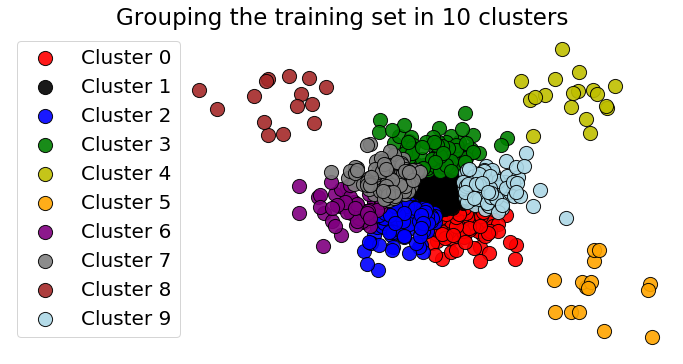

In [5]:
clusters = 10      #if you set a number greater than 10, you have to add colors in the map LABEL_COLOR_MAP.
cluster_labels = KMeans(n_clusters=clusters, random_state=331).fit(X_train).labels_
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'k',
                   2 : 'b',
                   3 : 'g',
                   4 : 'y',
                   5 : 'orange',
                   6 : 'purple',
                   7 : 'grey',
                   8 : 'brown',
                   9 : 'lightblue',
                   }

label_color = [LABEL_COLOR_MAP[l] for l in cluster_labels]
plt.figure(figsize = (12,6))
for i in range(len(np.unique(cluster_labels))):
    idx = np.where(cluster_labels == i)
    plt.scatter(X_train.T[0][idx], X_train.T[1][idx], 200, c=LABEL_COLOR_MAP[i], label = 'Cluster '+str(i),
                edgecolor = 'black', alpha = 0.9)
plt.axis('off')
plt.xlim(-11,6.5)
plt.legend(ncol=1, fontsize = 20)
plt.title("Grouping the training set in 10 clusters", fontsize = 23)
plt.show()

In [6]:
                            #BIASED sample weights
knno_stab_bias, knno_inst_bias = stability_measure(X_train, X_test, knno, gamma, unif = False)

iforest_stab_bias, iforest_inst_bias = stability_measure(X_train, X_test, iforest, gamma, unif = False)

lof_stab_bias, lof_inst_bias = stability_measure(X_train, X_test, lof, gamma, unif = False)

print("Computing the Ranking Stability Metric with Bias Sampling:\n\n- KNNO Stability:", knno_stab_bias,
      "\n- IForest Stability:", iforest_stab_bias, "\n- LOF Stability:", lof_stab_bias)

Computing the Ranking Stability Metric with Bias Sampling:

- KNNO Stability: 0.867731820329507 
- IForest Stability: 0.9574746932776369 
- LOF Stability: 0.3330612114768424
